In [9]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics


%matplotlib inline

# Load the Data

In [12]:
df = pd.read_csv("cleaned_plyear_data.csv")

In [14]:
df

,Team,Position,Height,Age,Appearances,Goals,Assists,Yellow_Cards,Second_Yellow_Cards,Red_Cards,Goals_Conceded,Clean_Sheets,Minutes_Played,Days_Injured,Games_Injured,Award,Current_Value,Highest_Value,Position_Encoded,Winger
0,Manchester United,Goalkeeper,196.000000,30.0,15,0.000000,0.000000,0.069018,0.0,0.000000,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0
1,Manchester United,Goalkeeper,188.000000,37.0,4,0.000000,0.000000,0.000000,0.0,0.000000,0.616438,0.924658,292,697,84,4,600000,6000000,1,0
2,Manchester United,Defender Centre-Back,185.000000,31.0,8,0.000000,0.000000,0.216346,0.0,0.000000,0.000000,0.000000,416,932,169,7,2000000,20000000,2,0
3,Manchester United,Defender Centre-Back,186.000000,21.0,34,0.000000,0.000000,0.130529,0.0,0.000000,0.000000,0.000000,2758,47,13,0,2000000,2000000,2,0
4,Manchester United,Defender Left-Back,169.000000,23.0,89,0.012619,0.063096,0.227145,0.0,0.000000,0.000000,0.000000,7132,182,15,3,22000000,22000000,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10298,Western Sydney Wanderers,Attack-RightWinger,181.240353,20.0,16,0.175953,0.087977,0.263930,0.0,0.000000,0.000000,0.000000,1023,0,0,0,75000,75000,4,1
10299,Western Sydney Wanderers,Attack Centre-Forward,190.000000,24.0,26,0.372671,0.186335,0.186335,0.0,0.000000,0.000000,0.000000,1449,102,18,0,300000,300000,4,0
10300,Western Sydney Wanderers,Attack Centre-Forward,181.240353,19.0,20,0.375000,0.000000,0.187500,0.0,0.000000,0.000000,0.000000,960,0,0,0,50000,50000,4,0
10301,Western Sydney Wanderers,Attack Centre-Forward,181.240353,20.0,17,0.312139,0.104046,0.000000,0.0,0.104046,0.000000,0.000000,865,0,0,0,50000,50000,4,0


# Aggregat
Aggregating categorical feature

In [17]:
categorical_features = df.select_dtypes(include=['object']).columns
categorical_features

Index(['Team', 'Position'], dtype='object')

# One hot coding

In [20]:
df = pd.get_dummies(df, columns=categorical_features)

In [22]:
df.shape

(10303, 405)

# Split the players to 3 categories by percentiles

In [25]:
#p30 = df['Current_Value'].quantile(0.30)
p60 = df['Current_Value'].quantile(0.60)
p90 = df['Current_Value'].quantile(0.90)

# Function to categorize prices
def categorize_Current_Value(Current_Value):
    
    if Current_Value < p60:
        return 'good player'
    elif Current_Value < p90:
        return 'Excellent player'
    else:
        return 'legend'

# Apply the function to create a new column
df['categorize_Current_Value'] = df['Current_Value'].apply(categorize_Current_Value)

df.drop('Current_Value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['categorize_Current_Value'].value_counts())

categorize_Current_Value
good player         5798
Excellent player    3361
legend              1144
Name: count, dtype: int64


# encoder

In [28]:
encoder = LabelEncoder()
df['categorize_Current_Value'] = encoder.fit_transform(df['categorize_Current_Value'])  

# Feature selection

In [31]:
correlation = df.corr(numeric_only=True)
print(correlation['categorize_Current_Value'].sort_values(ascending=False))

categorize_Current_Value    1.000000
Highest_Value               0.250882
Team_Southampton FC         0.076884
Team_AS Monaco              0.071370
Team_Atalanta BC            0.062326
                              ...   
Team_Real Valladolid CF    -0.041331
Days_Injured               -0.041717
Games_Injured              -0.043376
Team_Elche CF              -0.047664
Age                        -0.079042
Name: categorize_Current_Value, Length: 405, dtype: float64


In [33]:
threshold = 0.07 
selected_features = correlation[abs(correlation['categorize_Current_Value']) > \
threshold]['categorize_Current_Value'].index
selected_features

Index(['Age', 'Highest_Value', 'Team_AS Monaco', 'Team_Southampton FC',
       'categorize_Current_Value'],
      dtype='object')

In [35]:
selected_features =['Age', 'Highest_Value', 'Team_AS Monaco', 'Team_Southampton FC',
       'categorize_Current_Value']

# Data Scaling

In [38]:
#drop categorize_Current_Value column
X = df.drop(['categorize_Current_Value'], axis=1)


# sacle the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Buliding the Model
Bulid aLogisticr Regression Model

In [94]:
wcss = []
for i in range(5, 30):  # Test 1 to 10 clusters
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Drawing the elbow curve

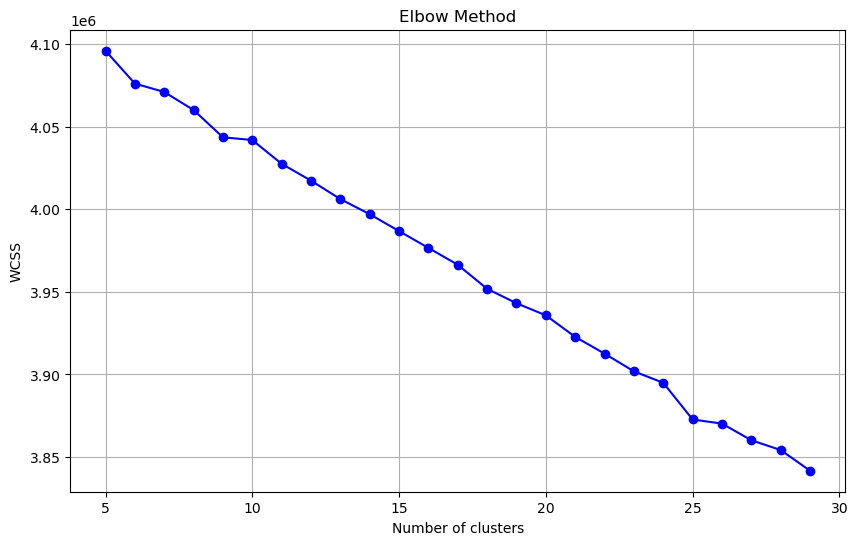

In [96]:
plt.figure(figsize=(10, 6))
plt.plot(range(5, 30), wcss,  marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

## optimal K clusters)

In [144]:
optimal_clusters = 9
model = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)

# Train the model

In [147]:
y_pred = model.fit_predict(X_scaled)

## Clusters

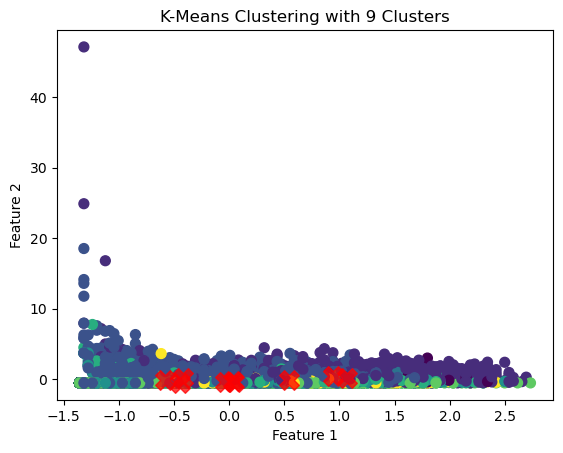

In [149]:
plt.scatter(X_scaled[:, 2], X_scaled[:, 3], c=y_pred, s=50, cmap='viridis')

centers = model.cluster_centers_
plt.scatter(centers[:, 2], centers[:, 3], c='red', s=200, alpha=0.75, marker='X')
plt.title(f'K-Means Clustering with {optimal_clusters} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [150]:
X['kmeans'] = y_pred

In [151]:
X['kmeans'].value_counts()

kmeans
2    3413
1    2079
4    1720
6    1197
5    1031
8     776
7      30
3      30
0      27
Name: count, dtype: int64

In [152]:
X[X['kmeans']==0]

,Height,Age,Appearances,Goals,Assists,Yellow_Cards,Second_Yellow_Cards,Red_Cards,Goals_Conceded,Clean_Sheets,...,Position_Defender Centre-Back,Position_Defender Left-Back,Position_Defender Right-Back,Position_Goalkeeper,Position_midfield-AttackingMidfield,Position_midfield-CentralMidfield,Position_midfield-DefensiveMidfield,Position_midfield-LeftMidfield,Position_midfield-RightMidfield,kmeans
5837,198.0,25.0,71,0.000000,0.000000,0.070291,0.000000,0.000000,1.110590,0.351453,...,False,False,False,True,False,False,False,False,False,0
5838,193.0,24.0,46,0.000000,0.000000,0.107914,0.000000,0.000000,1.424460,0.151079,...,False,False,False,True,False,False,False,False,False,0
5839,188.0,20.0,11,0.000000,0.000000,0.000000,0.000000,0.000000,1.093923,0.397790,...,False,False,False,True,False,False,False,False,False,0
5840,192.0,25.0,95,0.046077,0.046077,0.161270,0.000000,0.000000,0.000000,0.000000,...,True,False,False,False,False,False,False,False,False,0
5841,190.0,28.0,70,0.016450,0.065801,0.180954,0.000000,0.016450,0.000000,0.000000,...,True,False,False,False,False,False,False,False,False,0
5842,190.0,29.0,75,0.067547,0.000000,0.175623,0.000000,0.000000,0.000000,0.000000,...,True,False,False,False,False,False,False,False,False,0
5843,196.0,30.0,23,0.153671,0.102447,0.204895,0.000000,0.000000,0.000000,0.000000,...,True,False,False,False,False,False,False,False,False,0
5844,183.0,32.0,51,0.048583,0.048583,0.388664,0.000000,0.000000,0.000000,0.000000,...,True,False,False,False,False,False,False,False,False,0
5845,178.0,24.0,79,0.143592,0.287183,0.111682,0.015955,0.000000,0.000000,0.000000,...,False,True,False,False,False,False,False,False,False,0
5846,189.0,22.0,44,0.029402,0.000000,0.235217,0.029402,0.000000,0.000000,0.000000,...,False,True,False,False,False,False,False,False,False,0


<Axes: xlabel='Appearances', ylabel='Age'>

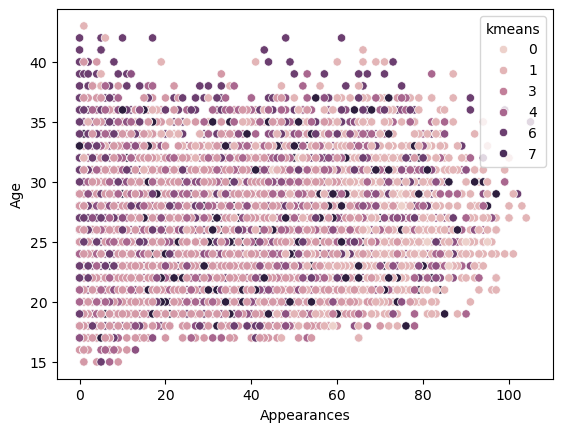

In [153]:
sns.scatterplot(data = X , x = 'Appearances', y = 'Age', hue = 'kmeans')

<Axes: xlabel='Highest_Value', ylabel='Age'>

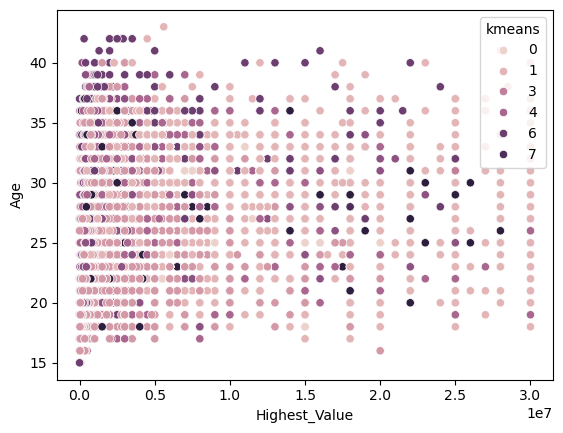

In [155]:
sns.scatterplot(data = X , x = 'Highest_Value', y = 'Age', hue = 'kmeans')